In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

## test offset

(1067, 64)


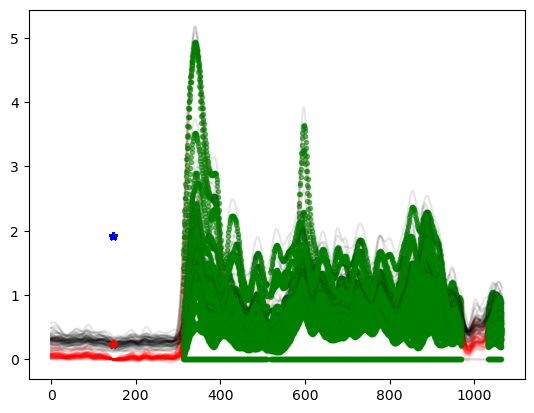

In [14]:
test_subject_idx = 13
test_subject = subjects[test_subject_idx]
trial = test_subject.tasks[task_name].sorted_sessions()[1].sorted_trials()[8]
signal = trial.get_filtered_emg()
hold_steps = int(200*trial.hold_time)
offset_signal = signal - signal[trial.low_point]
print(offset_signal.shape)
plt.figure(figsize=(10,10))
for channel in range(64):
    plt.plot(signal[:,channel],"k",alpha=0.1)
    plt.plot(trial.low_point, np.linalg.norm(signal, axis=1)[trial.low_point],"b*")
    plt.plot(trial.low_point, np.mean(signal, axis=1)[trial.low_point],"r*")
    plt.plot(offset_signal[:,channel],"r",alpha=0.1)
    plt.plot(trial.active_indices, offset_signal[trial.active_indices,channel],"g.",alpha=0.5)

## get trajectory stack

- only active indices, no hold steps
- subtracting activity at the lowest norm index from channels

In [18]:
max_traj_len = 0
max_sig_len = 0
for subject in subjects:
    for session in subject.tasks[task_name].sorted_sessions():
        for trial in session.sorted_trials():
            hold_steps = int(200*trial.hold_time)
            traj = trial.get_trajectory()[hold_steps:,:]
            sig = trial.get_filtered_emg()[hold_steps:,:]
            if traj.shape[0] > max_traj_len:
                max_traj_len = traj.shape[0]
            if sig.shape[0] > max_sig_len:
                max_sig_len = sig.shape[0]
print("Max trajectory length: " , max_traj_len)
print("Max signal length: " , max_sig_len)

# subject, session, target, time, x/y
subject_traj_stack = np.empty(shape=(len(subjects), 45, 12, max_traj_len, 2))
subject_traj_stack[:] = np.nan
subject_emg_stack = np.empty(shape=(len(subjects), 45, 12, max_sig_len, 64))
subject_emg_stack[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:45]):
        for target_idx in range(1,13):
            for trial_idx, trial in enumerate(session.sorted_trials()):
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    hold_steps = int(200*trial.hold_time)
                    traj = trial.get_trajectory()[trial.active_indices]
                    subject_traj_stack[subject_idx, session_idx, target_idx-1, :traj.shape[0], :] = traj
                    signal = trial.get_filtered_emg()
                    signal = signal - signal[trial.low_point]
                    signal = signal[trial.active_indices]
                    subject_emg_stack[subject_idx, session_idx, target_idx-1, :signal.shape[0], :] = signal
                    # if traj.shape[0] < max_len:
                    #     interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = interp_trajectory(x,traj[:,:])
                    # else:
                    #     interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = traj[:,:]

print(subject_traj_stack.shape)
print(subject_emg_stack.shape)

Max trajectory length:  1070
Max signal length:  1072
(46, 45, 12, 1070, 2)
(46, 45, 12, 1072, 64)


In [26]:
# np.save("subject_traj_stack.npy", subject_traj_stack)

subject_traj_stack = np.load("subject_traj_stack.npy")
print(subject_traj_stack.shape)

(46, 45, 12, 1070, 2)


In [22]:
# np.save("subject_emg_stack.npy", subject_emg_stack)

subject_emg_stack = np.load("subject_emg_stack.npy")
print(subject_emg_stack.shape)

(46, 45, 12, 1072, 64)


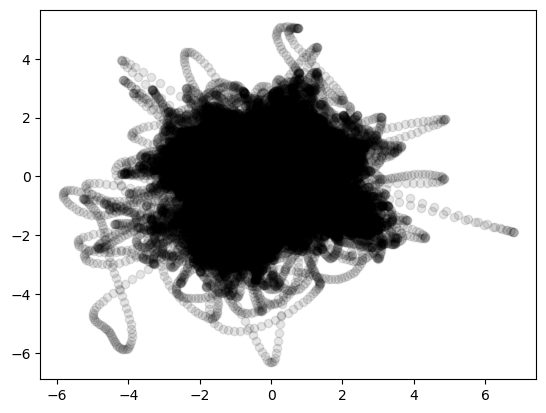

In [23]:
decoded_emg = subject_emg_stack[test_subject_idx].reshape(-1,64) @ subjects[test_subject_idx].decoder[-2:,:].T
plt.plot(decoded_emg[:,0],decoded_emg[:,1],"ko",alpha=0.1)
plt.plot()